In [187]:
from sklearn import tree
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split,KFold,cross_val_score,StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import f1_score,accuracy_score,mean_absolute_error,mean_squared_error
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from mlxtend.preprocessing import minmax_scaling
import featuretools as ft
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import pandas as pd
import math
import random
import numpy as np
from pandas_profiling import ProfileReport
from scipy import stats
import plotly.express as px



In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("Colour Test.csv")

df

L_label  a_label  b_label Construction BackingLayer2nd  \
0        34.478    3.335  -12.089         SD88           White   
1        30.657    3.465  -10.771       SDD248           White   
2        30.980    3.437  -10.747       SDD248           White   
3        29.781    3.538  -10.785        DD164           White   
4        29.579    3.607  -10.847        DD164           White   
...         ...      ...      ...          ...             ...   
114942   84.950  -10.300   40.410          D88           White   
114943   74.460  -29.410   43.570         SD88           Black   
114944   99.510  -44.600   73.730          D88           White   
114945   52.720   27.030   27.760        SD510           Black   
114946   77.220   61.700   54.560       SDD248           White   

       PatternLayer3rd                      YarnCode  L_weft  a_weft  b_weft  \
0                 NONE              LY0751213-005855  27.313   3.818 -10.501   
1                 NONE              LY0751213-005855  27.313   3.818 -10.501   
2                 NONE              LY0751213-005855  27.313   3.818 -10.501   
3                 NONE              LY0751213-005855  27.313   3.818 -10.501   
4                 NONE              LY0751213-005855  27.313   3.818 -10.501   
...                ...                           ...     ...     ...     ...   
114942               B     LY0501112-004933-WT-D88-B     NaN     NaN     NaN   
114943               B    LY0010-003950-75-BS-SD88-B     NaN     NaN     NaN   
114944               B     LY0010-003950-75-WT-D88-B     NaN     NaN     NaN   
114945               B   LY1001113-005981-BS-SD510-B     NaN     NaN     NaN   
114946               B  LY1001113-005981-WS-SDD248-B     NaN     NaN     NaN   

       WeftDenier  WeftYarnType WarpColor WeavingMachine  
0             75D          1213     White          Satin  
1             75D          1213     Black          Satin  
2             75D          1213     White          Satin  
3             75D          1213     Black        Taffeta  
4             75D          1213     White        Taffeta  
...           ...           ...       ...            ...  
114942        75D          1211     White        Taffeta  
114943        75D          1211     Black          Satin  
114944        75D          1211     White        Taffeta  
114945        75D          1211     Black          Satin  
114946        75D          1211     White          Satin  

[114947 rows x 14 columns]

In [188]:
df = pd.read_csv("Colour Test.csv")
df.fillna(0,inplace= True)
df.drop(columns=['YarnCode'],inplace=True)
df.drop(df[df.L_weft == 0].index,inplace=True)
df["chroma"] = (df.a_label**2 + df.b_label**2)**(1/2)
chroma_mean = df.chroma.mean()
df["chroma"] = df["chroma"].apply(lambda x: x if 0<=x<=100 else chroma_mean)
df["hue"] = np.arctan(df["b_label"]/df["a_label"])
df["mean_labels"] = df[["L_label","a_label","b_label"]].mean(axis=1)
df["median_labels"] = df[["L_label","a_label","b_label"]].median(axis=1)
df["lb_mean"] = df[["L_label","b_label"]].mean(axis=1)
df["lb_median"] = df[["L_label","b_label"]].median(axis=1)
a_mean = df.a_label.mean()
b_mean = df.b_label.mean()
l_mean = df.L_label.mean()
df["a_label"] = df["a_label"].apply(lambda x: x if -86.185<=x<=98.254 else a_mean) 
df["b_label"] = df["b_label"].apply(lambda x: x if -107.863<=x<=94.482 else b_mean)
#df["L_label"] = df["L_label"].apply(lambda x: x if x<=100 else l_mean)




def constuction_func(x):
    if 'SD' in x:
        return 1
    elif 'T' in x:
        return 2
    return 0
df["Construction_feat1"] = [constuction_func(i) for i in df.Construction]


def yarn_weigth(x):
    if x == 1111:
        return
    

        
#df["constfeat_back_mean"]=df[["Construction_feat1","BackingLayer2nd"]].mean(axis=1)


delta_df = pd.DataFrame()
delta_df_train = pd.DataFrame()


df

L_label   a_label    b_label Construction BackingLayer2nd  \
0       34.47800  3.335000 -12.089000         SD88           White   
1       30.65700  3.465000 -10.771000       SDD248           White   
2       30.98000  3.437000 -10.747000       SDD248           White   
3       29.78100  3.538000 -10.785000        DD164           White   
4       29.57900  3.607000 -10.847000        DD164           White   
...          ...       ...        ...          ...             ...   
114878  86.24818 -9.722858   3.251195        DD164        Original   
114879  81.18523 -5.026460   0.591886        DD164           White   
114880  81.17082 -5.086213   0.662887        DD164           White   
114881  80.92577 -5.045742   0.649619        DD164           White   
114882  80.79858 -5.081386   0.773394        DD164        Original   

       PatternLayer3rd  L_weft  a_weft  b_weft WeftDenier  WeftYarnType  \
0                 NONE  27.313   3.818 -10.501        75D          1213   
1                 NONE  27.313   3.818 -10.501        75D          1213   
2                 NONE  27.313   3.818 -10.501        75D          1213   
3                 NONE  27.313   3.818 -10.501        75D          1213   
4                 NONE  27.313   3.818 -10.501        75D          1213   
...                ...     ...     ...     ...        ...           ...   
114878            NONE  84.432  -8.272   2.727        75D          1211   
114879               B  84.432  -8.272   2.727        75D          1211   
114880               R  84.432  -8.272   2.727        75D          1211   
114881               Y  84.432  -8.272   2.727        75D          1211   
114882            NONE  84.432  -8.272   2.727        75D          1211   

       WarpColor WeavingMachine     chroma       hue  mean_labels  \
0          White          Satin  12.540580 -1.301621     8.574667   
1          Black          Satin  11.314622 -1.259555     7.783667   
2          White          Satin  11.283217 -1.261266     7.890000   
3          Black        Taffeta  11.350492 -1.253810     7.511333   
4          White        Taffeta  11.431004 -1.249765     7.446333   
...          ...            ...        ...       ...          ...   
114878     White        Taffeta  10.252036 -0.322698    26.592172   
114879     Black        Taffeta   5.061189 -0.117214    25.583552   
114880     Black        Taffeta   5.129228 -0.129600    25.582498   
114881     Black        Taffeta   5.087388 -0.128042    25.509882   
114882     Black        Taffeta   5.139905 -0.151042    25.496863   

        median_labels    lb_mean  lb_median  Construction_feat1  
0            3.335000  11.194500  11.194500                   1  
1            3.465000   9.943000   9.943000                   1  
2            3.437000  10.116500  10.116500                   1  
3            3.538000   9.498000   9.498000                   0  
4            3.607000   9.366000   9.366000                   0  
...               ...        ...        ...                 ...  
114878       3.251195  44.749688  44.749688                   0  
114879       0.591886  40.888558  40.888558                   0  
114880       0.662887  40.916854  40.916854                   0  
114881       0.649619  40.787695  40.787695                   0  
114882       0.773394  40.785987  40.785987                   0  

[114883 rows x 20 columns]

In [189]:
set(df.WeftYarnType)

{1111, 1112, 1113, 1121, 1131, 1141, 1211, 1213, 1221, 1231, 1241}

In [190]:
df.a_label.describe()


count    114883.000000
mean          6.226925
std          22.909148
min         -74.570180
25%          -2.893895
50%           0.972569
75%          13.255985
max          97.511530
Name: a_label, dtype: float64

In [191]:


fig = px.scatter(x=df['a_label'], y=df['b_label'])

fig.show()

In [192]:



for i in ["Construction","BackingLayer2nd","PatternLayer3rd","WeftYarnType","WarpColor","WeavingMachine"]:
    df[i] = LabelEncoder().fit_transform(df[i])
df["back_const"] = df[["BackingLayer2nd","Construction"]].mean(axis=1)
df["WeftDenier"] = df["WeftDenier"].apply(lambda x:int(''.join(list(x)[0:-1])))
#'Construction', 'BackingLayer2nd','PatternLayer3rd', 'WeftDenier','WeftYarnType', 'WarpColor', 'WeavingMachine', ,'Construction_feat1',, 'chroma', 'hue'
for i in ['a_label', 'b_label']:
    df[i+"_L_mean"] = df[[i,'L_label']].mean(axis=1)

df["a_b_mean"] = df[['a_label', 'b_label']].mean(axis=1)

for i in df.columns:
    if i not in ["L_weft","a_weft","b_weft","chroma"]:
        df["chroma"+i+"_mean"] = df[[i,'chroma']].mean(axis=1)

for i in df.columns:
    if i not in ["L_weft","a_weft","b_weft","hue"]:
        df["hue"+i+"_mean"] = df[[i,'hue']].mean(axis=1)

y = df[["L_weft","a_weft","b_weft"]]


#x = minmax_scaling(df,columns=[i for i in df.columns if i not in ["L_weft","a_weft","b_weft","PatternLayer3rd"]])
x = df[[i for i in df.columns if i not in ["L_weft","a_weft","b_weft","WeftDenier"]]]





df

L_label   a_label    b_label  Construction  BackingLayer2nd  \
0       34.47800  3.335000 -12.089000             5                2   
1       30.65700  3.465000 -10.771000             6                2   
2       30.98000  3.437000 -10.747000             6                2   
3       29.78100  3.538000 -10.785000             3                2   
4       29.57900  3.607000 -10.847000             3                2   
...          ...       ...        ...           ...              ...   
114878  86.24818 -9.722858   3.251195             3                1   
114879  81.18523 -5.026460   0.591886             3                2   
114880  81.17082 -5.086213   0.662887             3                2   
114881  80.92577 -5.045742   0.649619             3                2   
114882  80.79858 -5.081386   0.773394             3                1   

        PatternLayer3rd  L_weft  a_weft  b_weft  WeftDenier  ...  \
0                     1  27.313   3.818 -10.501          75  ...   
1                     1  27.313   3.818 -10.501          75  ...   
2                     1  27.313   3.818 -10.501          75  ...   
3                     1  27.313   3.818 -10.501          75  ...   
4                     1  27.313   3.818 -10.501          75  ...   
...                 ...     ...     ...     ...         ...  ...   
114878                1  84.432  -8.272   2.727          75  ...   
114879                0  84.432  -8.272   2.727          75  ...   
114880                2  84.432  -8.272   2.727          75  ...   
114881                3  84.432  -8.272   2.727          75  ...   
114882                1  84.432  -8.272   2.727          75  ...   

        huechromahue_mean_mean  huechromamean_labels_mean_mean  \
0                     2.158929                        4.628001   
1                     1.883989                        4.144795   
2                     1.874855                        4.162671   
3                     1.897266                        4.088551   
4                     1.920427                        4.094452   
...                        ...                             ...   
114878                2.320985                        9.049703   
114879                1.177386                        7.602578   
114880                1.185107                        7.613132   
114881                1.175816                        7.585297   
114882                1.171695                        7.583671   

        huechromamedian_labels_mean_mean  huechromalb_mean_mean_mean  \
0                               3.318085                    5.282960   
1                               3.065128                    4.684628   
2                               3.049421                    4.719296   
3                               3.095218                    4.585218   
4                               3.134619                    4.574369   
...                                  ...                         ...   
114878                          3.214459                   13.589082   
114879                          1.354661                   11.428829   
114880                          1.383229                   11.446721   
114881                          1.370231                   11.404750   
114882                          1.402804                   11.405952   

        huechromalb_median_mean_mean  huechromaConstruction_feat1_mean_mean  \
0                           5.282960                               2.734335   
1                           4.684628                               2.448878   
2                           4.719296                               2.440171   
3                           4.585218                               2.210718   
4                           4.574369                               2.232869   
...                              ...                                    ...   
114878                     13.589082                               2.401660   
114879                     11.428829 

Text(0.5, 1.0, 'Correlation Heatmap')

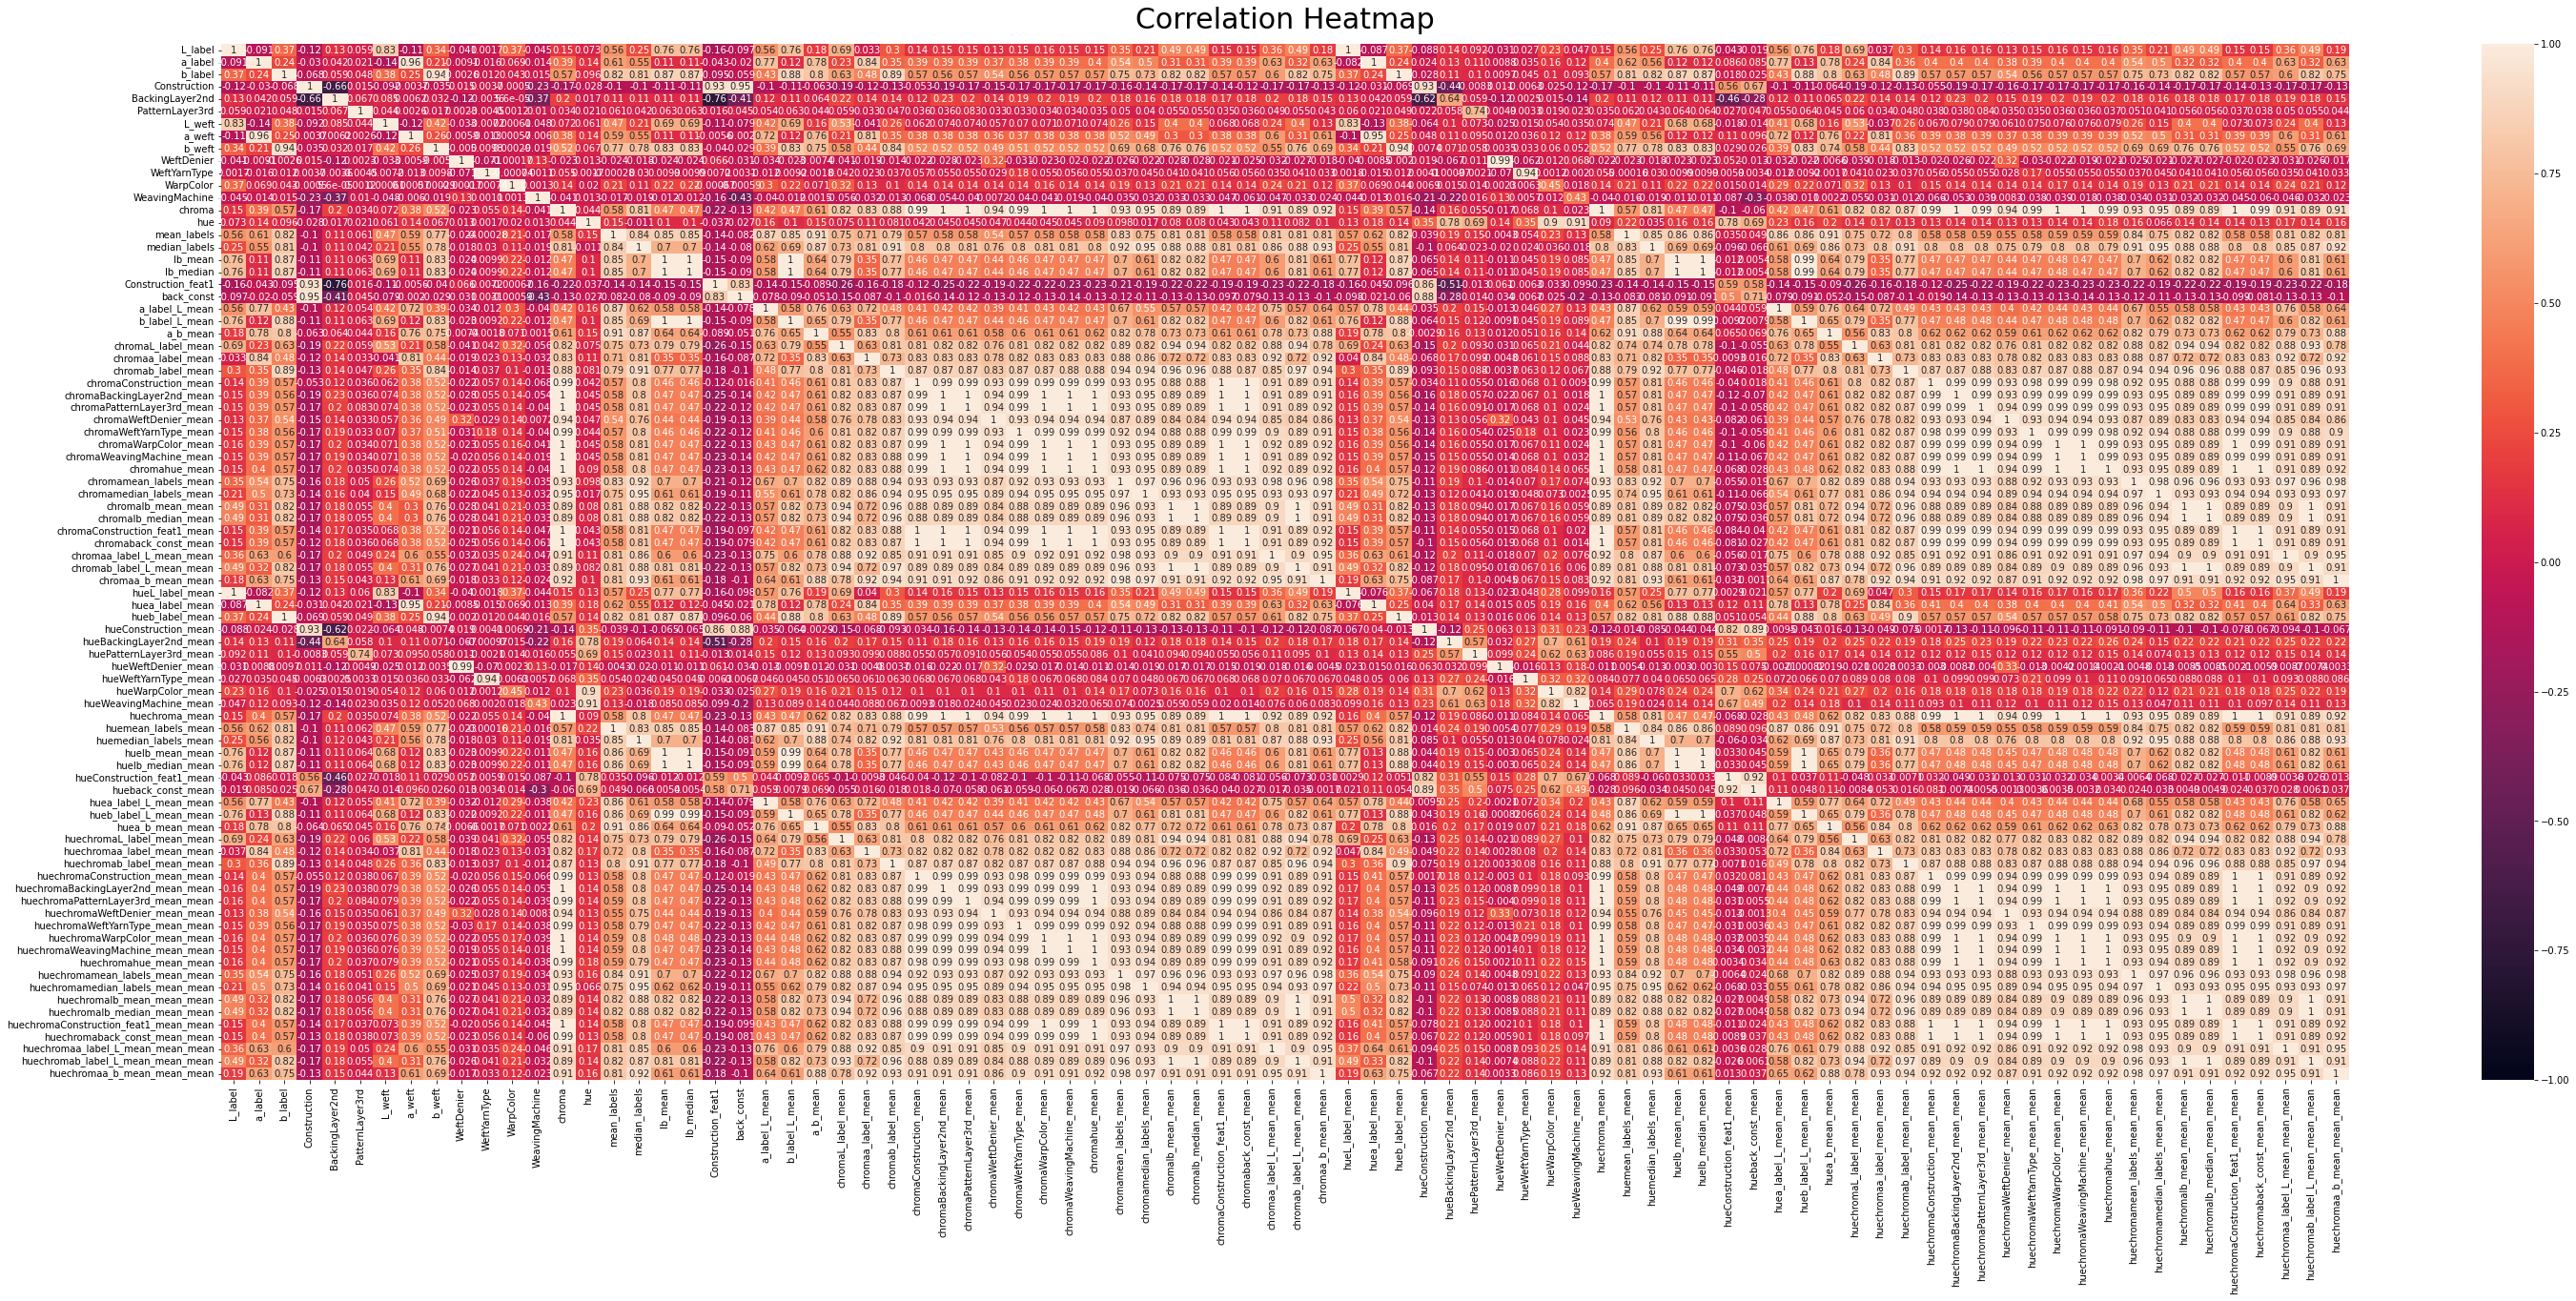

In [193]:
plt.figure(figsize=(50, 20))

heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True,)

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':30}, pad=16)

In [194]:
df.corr()['Construction']

L_label                                 -0.122343
a_label                                 -0.030197
b_label                                 -0.067844
Construction                             1.000000
BackingLayer2nd                         -0.663331
                                           ...   
huechromaConstruction_feat1_mean_mean   -0.137128
huechromaback_const_mean_mean           -0.125051
huechromaa_label_L_mean_mean_mean       -0.168266
huechromab_label_L_mean_mean_mean       -0.166100
huechromaa_b_mean_mean_mean             -0.134469
Name: Construction, Length: 84, dtype: float64

In [195]:
x.columns

Index(['L_label', 'a_label', 'b_label', 'Construction', 'BackingLayer2nd',
       'PatternLayer3rd', 'WeftYarnType', 'WarpColor', 'WeavingMachine',
       'chroma', 'hue', 'mean_labels', 'median_labels', 'lb_mean', 'lb_median',
       'Construction_feat1', 'back_const', 'a_label_L_mean', 'b_label_L_mean',
       'a_b_mean', 'chromaL_label_mean', 'chromaa_label_mean',
       'chromab_label_mean', 'chromaConstruction_mean',
       'chromaBackingLayer2nd_mean', 'chromaPatternLayer3rd_mean',
       'chromaWeftDenier_mean', 'chromaWeftYarnType_mean',
       'chromaWarpColor_mean', 'chromaWeavingMachine_mean', 'chromahue_mean',
       'chromamean_labels_mean', 'chromamedian_labels_mean',
       'chromalb_mean_mean', 'chromalb_median_mean',
       'chromaConstruction_feat1_mean', 'chromaback_const_mean',
       'chromaa_label_L_mean_mean', 'chromab_label_L_mean_mean',
       'chromaa_b_mean_mean', 'hueL_label_mean', 'huea_label_mean',
       'hueb_label_mean', 'hueConstruction_mean', 'hueBack

L_weft training

In [196]:
"""delta_df = pd.DataFrame()
delta_df_train = pd.DataFrame()"""


y_l = df["L_weft"]

X_train,X_test,Y_train,Y_test = train_test_split(x,y_l, test_size=0.1, random_state=20,shuffle=True)

delta_df["real_l"] = Y_test
delta_df_train["real_l"] = Y_train

m1 = KNeighborsRegressor()
m2 = RandomForestRegressor()
m3 = xgb.XGBRegressor()
m4 = lgb.LGBMRegressor()
model_l = lgb.LGBMRegressor(n_estimators=350,max_depth=10,num_leaves=400,learning_rate=0.3,num_iterations=1100)

    
model_l.fit(X_train,Y_train)

    


y_pred_l = model_l.predict(X_test)
y_pred_l_train = model_l.predict(X_train)

"""delta_df["predicted_l"] = y_pred_l
delta_df_train["predicted_l"] = y_pred_l_train

delta_df["delta_l"] = delta_df.predicted_l - delta_df.real_l
final_delta_l = delta_df["delta_l"]"""


mae_l = mean_absolute_error(Y_test,y_pred_l)
mse_l = mean_squared_error(Y_test,y_pred_l)
rmse_l = mean_squared_error(Y_test,y_pred_l,squared=False)

print("mse",mse_l)
print("mae",mae_l)
print("rmse",rmse_l)

mse 2.456929430996402
mae 0.9313380211537089
rmse 1.5674595468452772


In [197]:
Y_test

3022     78.023
31345    83.190
46493    55.845
40554    67.147
50054    24.579
          ...  
15679    72.731
78497    37.628
12119    70.725
56014    56.385
82132    37.332
Name: L_weft, Length: 11489, dtype: float64

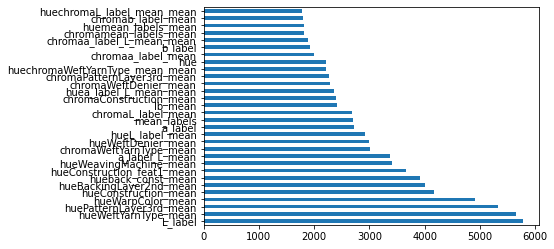

In [198]:
feat_importances_l = pd.Series(model_l.feature_importances_, index=x.columns)
feat_importances_l.nlargest(30).plot(kind='barh')
plt.show()

a_weft training

In [199]:
"""delta_df = pd.DataFrame()
delta_df_train = pd.DataFrame()"""

y_a = df["a_weft"]

X_train,X_test,Y_train,Y_test = train_test_split(x,y_a, test_size=0.1, random_state=20,shuffle=True)

delta_df["real_a"] = Y_test
delta_df_train["real_a"] = Y_train



model_a = lgb.LGBMRegressor(n_estimators=300,max_depth=10,num_leaves=635,learning_rate=0.2,feature_fraction=0.9,max_bin=70,num_iterations=1200)

#model_a = xgb.XGBRegressor()
    
model_a.fit(X_train,Y_train)

    


y_pred_a = model_a.predict(X_test)
y_pred_a_train = model_a.predict(X_train)

"""delta_df["predicted_a"] = y_pred_a
delta_df_train["predicted_a"] = y_pred_a_train

delta_df["delta_a"] = delta_df.predicted_a - delta_df.real_a
final_delta_a = delta_df["delta_a"]"""


mae_a = mean_absolute_error(Y_test,y_pred_a)
mse_a = mean_squared_error(Y_test,y_pred_a)
rmse_a = mean_squared_error(Y_test,y_pred_a,squared=False)


print("mse",mse_a)
print("mae",mae_a)
print("rmse",rmse_a)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
mse 3.5669525652939127
mae 0.9058037263432756
rmse 1.8886377538569732


23

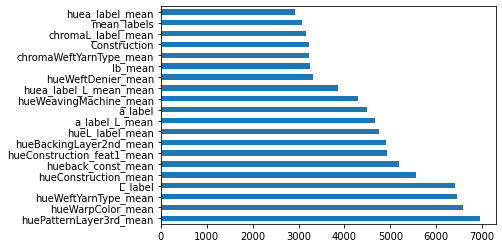

In [200]:
feat_importances_a = pd.Series(model_a.feature_importances_, index=x.columns)
feat_importances_a.nlargest(20).plot(kind='barh')
plt.show()

b_weft training

In [201]:
"""delta_df = pd.DataFrame()
delta_df_train = pd.DataFrame()"""

y_b = df["b_weft"]

X_train,X_test,Y_train,Y_test = train_test_split(x,y_b, test_size=0.1, random_state=20,shuffle=True)

delta_df["real_b"] = Y_test
delta_df_train["real_b"] = Y_train


model_b = lgb.LGBMRegressor(n_estimators=600,max_depth=20,num_leaves=700,learning_rate=0.05,feature_fraction=0.9)

 
model_b.fit(X_train,Y_train)

    


y_pred_b = model_b.predict(X_test)
y_pred_b_train = model_b.predict(X_train)

"""delta_df["predicted_b"] = y_pred_b
delta_df_train["predicted_b"] = y_pred_b_train

delta_df["delta_b"] = delta_df.predicted_b - delta_df.real_b
final_delta_b = delta_df["delta_b"]"""


mae_b = mean_absolute_error(Y_test,y_pred_b)
mse_b = mean_squared_error(Y_test,y_pred_b)
rmse_b = mean_squared_error(Y_test,y_pred_b,squared=False)

print("mse",mse_b)
print("mae",mae_b)
print("rmse",rmse_b)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
mse 4.480551589946676
mae 0.9485802130501751
rmse 2.116731345718364


In [202]:
np.mean([rmse_l,rmse_a,rmse_b])

1.8576095488068713

random = RandomizedSearchCV(estimator=model_b, param_distributions=dict(max_depth=range(15,60,2),num_leaves=[1024,2048]), cv = 3, n_jobs=-1)

random_result = random.fit(x, y_b)
# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

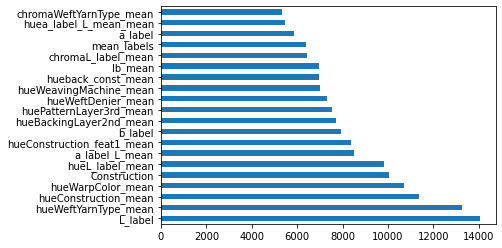

In [203]:
feat_importances_b = pd.Series(model_b.feature_importances_, index=x.columns)
feat_importances_b.nlargest(20).plot(kind='barh')
plt.show()

In [215]:
delta_df["predicted_l"] = y_pred_l
delta_df["predicted_a"] = y_pred_a
delta_df["predicted_b"] = y_pred_b

delta_df["delta_l"] = delta_df.predicted_l - delta_df.real_l
delta_df["delta_a"] = delta_df.predicted_a - delta_df.real_a
delta_df["delta_b"] = delta_df.predicted_b - delta_df.real_b
delta_df["dE"] = np.sqrt(np.square(delta_df.delta_l)+np.square(delta_df.delta_a)+np.square(delta_df.delta_b))
valid_de = len(delta_df.loc[delta_df.dE <= 2])
valid_per = valid_de*100/len(delta_df)

print(str(valid_per)+"%")

70.15406040560536%


In [218]:
print("Percentage of delta E higher than 2 in the test set :")
print(str(100 - valid_per)+"%")

Percentage of delta E higher than 2 in the test set :
29.845939594394636%


In [216]:
delta_df_train["predicted_l"] = y_pred_l_train
delta_df_train["predicted_a"] = y_pred_a_train
delta_df_train["predicted_b"] = y_pred_b_train

delta_df_train["delta_l"] = delta_df_train.predicted_l - delta_df_train.real_l
delta_df_train["delta_a"] = delta_df_train.predicted_a - delta_df_train.real_a
delta_df_train["delta_b"] = delta_df_train.predicted_b - delta_df_train.real_b
delta_df_train["dE"] = np.sqrt(np.square(delta_df_train.delta_l)+np.square(delta_df_train.delta_a)+np.square(delta_df_train.delta_b))
valid_de_train = len(delta_df_train.loc[delta_df_train.dE <= 2])
valid_per_train = valid_de_train*100/len(delta_df_train)

print(str(valid_per_train)+"%")

98.06371743041183%


total percentage

In [217]:
(valid_de + valid_de_train)*100/(len(delta_df_train)+len(delta_df))

95.27258167004692

In [207]:
mean_de_test = np.mean(delta_df.dE)
mean_de_train = np.mean(delta_df_train.dE)

In [208]:
print("="*75)
print("\t\t\tContest Conditions")
print("="*75)

print('\n')

print("Percentage of valid delta E :",str((valid_de + valid_de_train)*100/(len(delta_df_train)+len(delta_df)))+"%")
print("Average delta E : ",np.mean([mean_de_test,mean_de_train]))
print("RMSE mean :",np.mean([rmse_l,rmse_a,rmse_b]))
print("MSE mean :",np.mean([mse_l,mse_a,mse_b]))
print("MAE mean :",np.mean([mae_l,mae_a,mae_b]))

			Contest Conditions


Percentage of valid delta E : 95.72347518779976%
Average delta E :  1.2466615317137413
RMSE mean : 1.8576095488068713
MSE mean : 3.5014778620789966
MAE mean : 0.9285739868490532


In [209]:
df.L_weft.mean()

56.41015347788621

In [210]:
my_list = delta_df.loc[delta_df.dE > 5].index

In [211]:
delta_df

real_l  real_a  real_b  predicted_l  predicted_a  predicted_b  \
3022   78.023   6.951  19.434    76.845042     5.700396    16.713117   
31345  83.190 -14.109  81.778    81.475999   -14.462222    82.044133   
46493  55.845 -52.178  29.122    56.284560   -51.163780    28.910165   
40554  67.147  84.960  66.684    67.711139    84.882849    67.307473   
50054  24.579  18.423   4.673    24.741877    19.952506     4.558602   
...       ...     ...     ...          ...          ...          ...   
15679  72.731 -29.573   0.830    69.985174   -30.515096    -0.222957   
78497  37.628  55.105  28.231    37.642077    53.589594    27.852782   
12119  70.725 -24.126 -11.778    70.064069   -24.586247   -12.256403   
56014  56.385 -23.436  42.725    56.434938   -24.344093    43.389197   
82132  37.332  -6.545  18.217    37.711013    -7.522325    19.144907   

        delta_l   delta_a   delta_b        dE  
3022  -1.177958 -1.250604 -2.720883  3.217887  
31345 -1.714001 -0.353222  0.266133  1.770139  
46493  0.439560  1.014220 -0.211835  1.125490  
40554  0.564139 -0.077151  0.623473  0.844348  
50054  0.162877  1.529506 -0.114398  1.542403  
...         ...       ...       ...       ...  
15679 -2.745826 -0.942096 -1.052957  3.088013  
78497  0.014077 -1.515406 -0.378218  1.561954  
12119 -0.660931 -0.460247 -0.478403  0.936764  
56014  0.049938 -0.908093  0.664197  1.126181  
82132  0.379013 -0.977325  0.927907  1.399938  

[11489 rows x 10 columns]

In [212]:
y_pred_l

array([76.84504215, 81.47599899, 56.28455989, ..., 70.06406856,
       56.43493794, 37.7110127 ])

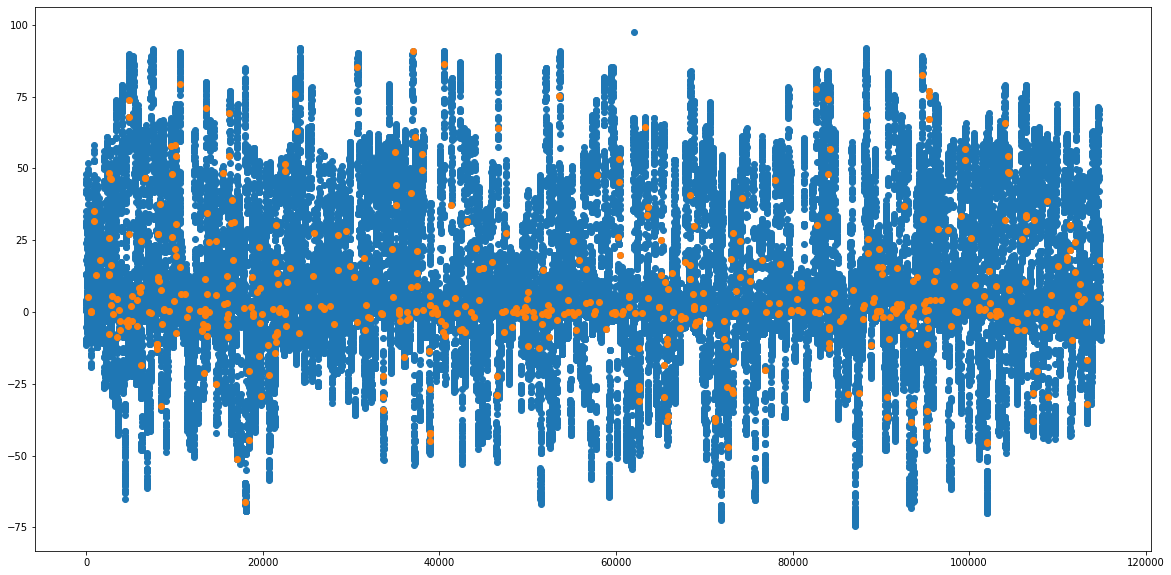

In [213]:
fig, ax = plt.subplots(figsize=(20,10))
"""ax.plot(df.index,df['L_label'])
ax.plot(delta_df.loc[delta_df.dE > 5].index,df.iloc[delta_df.loc[delta_df.dE > 5].index]['L_label'])"""

plt.scatter(df.index,df['a_label'])
plt.scatter(delta_df.loc[delta_df.dE > 5].index,df.iloc[delta_df.loc[delta_df.dE > 5].index]['a_label'])

In [214]:
df.iloc[delta_df.loc[delta_df.dE > 5]]

IndexError: DataFrame indexer is not allowed for .iloc
Consider using .loc for automatic alignment.

max_score = 10000
max_dict = {}


while(True):
    
    cols = list(x.columns)
    n_cols = len(cols)
    n_feat_to_add = random.randint(2,6)
    try:
        random_features = random.sample(cols,n_feat_to_add)
    except:
        print(cols)
        print(n_feat_to_add)
        break
    for i in range(n_feat_to_add):
        coeffs_dict = {i:j for i,j in zip(random_features,np.random.dirichlet(np.ones(n_feat_to_add),size=1).tolist()[0])}
        df['added_feature_'+str(i)] = sum([df[j] * coeffs_dict[j] for j in coeffs_dict.keys()])

        y_b = df["b_weft"]

        X_train,X_test,Y_train,Y_test = train_test_split(x,y_b, test_size=0.3, random_state=20,shuffle=True)

        delta_df["real_b"] = Y_test
        delta_df_train["real_b"] = Y_train


        model_b = lgb.LGBMRegressor(n_estimators=300,max_depth=10,num_leaves=500,learning_rate=0.3,num_iterations=1000)

        
        model_b.fit(X_train,Y_train)

            


        y_pred_b = model_b.predict(X_test)
        y_pred_b_train = model_b.predict(X_train)

        mae_b = mean_absolute_error(Y_test,y_pred_b)
        mse_b = mean_squared_error(Y_test,y_pred_b)
        rmse_b = mean_squared_error(Y_test,y_pred_b,squared=False)
        print("--------------------------------------------------------")
        print("Score :",rmse_b)
        print(coeffs_dict)
        if rmse_b < max_score:
            max_score = rmse_b
            max_dict = coeffs_dict
        print("MAX_SCORE :",max_score)
        print("------------------------------------------------")


    df = df.drop(columns=['added_feature_'+str(i) for i in range(n_feat_to_add)])

Add mean and median with l label for any other columns